In [1]:
#アンサンブル学習における、各決定木の出力の重み付けの概念について学習する
import numpy as np
import pandas as pd

#Weightend 多数決 
np.argmax(np.bincount([0,0,1], weights=[0.2,0.2,0.6]))
#決定木が0,0,1の出力を出してきているが、ウェイトが0.2,0.2,0.6である。
#そうなると1の出力を、他の出力の3倍重視することになる
#[0,0,1,1,1]となるので、多数決取ると1が予測結果になる

1

In [2]:
#決定木が多数決で予測結果を出力するプロセスをみる
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators


class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='classlabel')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        y : array-like, shape = [n_examples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_examples]
            Predicted class labels.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Training vectors, where n_examples is the number of examples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_examples, n_classes]
            Weighted average probability for each class per example.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out['%s__%s' % (name, key)] = value
            return out

In [3]:
#多数決の原理で実際に予測を行う、上のMajorityVoteClassifierを使う
#iris-datasetから2クラス分類にした上で、特徴量も2つに絞る
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

iris = load_iris()

X,y = iris.data[50:,[1,2]], iris.target[50:]

le = LabelEncoder()
y = le.fit_transform(y)

X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=0,stratify=y)#層化分割

In [4]:
#ロジスティック回帰、決定木、K最近傍法の3つのアルゴリズムを訓練し、交差検証で精度を確認する
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
import numpy as np


#logistic
clf1 = LogisticRegression(penalty='l2',C=0.01,solver='lbfgs',random_state=0)
#DTC
clf2 = DecisionTreeClassifier(max_depth=2,criterion='gini',random_state=0)
#KNeighbors
clf3 = KNeighborsClassifier(n_neighbors=1,p=2,metric='euclidean')

#pipeline1
pipe1 = make_pipeline(StandardScaler(),
                      clf1)
#pipeline2 決定木は標準化不要なのでpipeline作らない
#pipe2 = make_pipeline(StandardScaler(),
#                      clf2)

#pipeline3
pipe3 = make_pipeline(StandardScaler(),
                      clf3)

clf_labels = ['LR','DTC','KN']

print('10-fold cross validation')
for clf,label in zip([pipe1,clf2,pipe3],clf_labels):
    scores = cross_val_score(estimator=clf,
                            cv=10,
                            X=X_train,
                            y=y_train,
                            scoring='roc_auc')
    print('------')
    print('estimator:{} 10-cv mean_score:{}'.format(label,np.mean(scores)))
    print('estimator:{} score sd of 10-cv:{}'.format(label,np.std(scores)))

10-fold cross validation
------
estimator:LR 10-cv mean_score:0.9395833333333334
estimator:LR score sd of 10-cv:0.06551743830631827
------
estimator:DTC 10-cv mean_score:0.9229166666666668
estimator:DTC score sd of 10-cv:0.055355542731610086
------
estimator:KN 10-cv mean_score:0.8083333333333333
estimator:KN score sd of 10-cv:0.12247448713915893


In [5]:
#多数決投票クラスを使う
mv_clf = MajorityVoteClassifier(classifiers=[pipe1,clf2,pipe3])
clf_labels += ['Majority Voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf,clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print('------')
    print('estimator:{} 10-cv mean_score:{}'.format(label,np.mean(scores)))
    print('estimator:{} score sd of 10-cv:{}'.format(label,np.std(scores)))

------
estimator:LR 10-cv mean_score:0.9395833333333334
estimator:LR score sd of 10-cv:0.06551743830631827
------
estimator:DTC 10-cv mean_score:0.9229166666666668
estimator:DTC score sd of 10-cv:0.055355542731610086
------
estimator:KN 10-cv mean_score:0.8083333333333333
estimator:KN score sd of 10-cv:0.12247448713915893
------
estimator:Majority Voting 10-cv mean_score:0.9166666666666667
estimator:Majority Voting score sd of 10-cv:0.05818433351570392


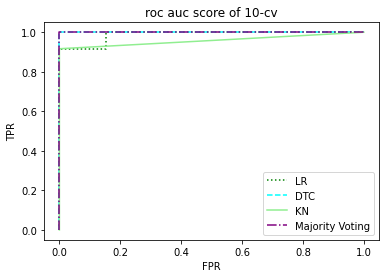

In [6]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
colors = ['green','cyan','lightgreen','purple']

linestyles = [':','--','-','-.']

for clf,label,clr,ls in zip(all_clf,clf_labels,colors,linestyles):
    #陽性クラスのラベルは1であることが前提。
    y_pred = clf.fit(X_train,y_train).predict_proba(X_test)[:,1]
    
    fpr,tpr,thresh = roc_curve(y_test,y_pred)
    roc_auc = auc(x=fpr,y=tpr)
    plt.plot(fpr,tpr,color=clr,linestyle=ls,label=label)
    plt.legend()
    plt.title('roc auc score of 10-cv')
    plt.xlabel('FPR')
    plt.ylabel('TPR')

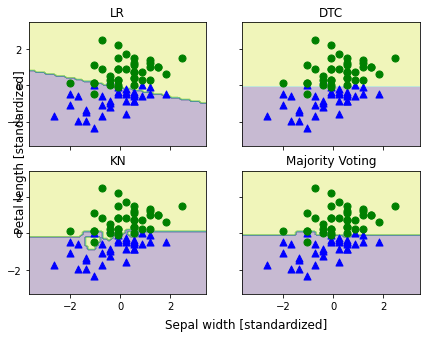

In [7]:
#決定境界を、各アルゴリズムごとに可視化する
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

from itertools import product

all_clf = [pipe1, clf2, pipe3, mv_clf]

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], 
                                  X_train_std[y_train==0, 1], 
                                  c='blue', 
                                  marker='^',
                                  s=50)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], 
                                  X_train_std[y_train==1, 1], 
                                  c='green', 
                                  marker='o',
                                  s=50)
    
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5., 
         s='Sepal width [standardized]', 
         ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5, 
         s='Petal length [standardized]', 
         ha='center', va='center', 
         fontsize=12, rotation=90)

#plt.savefig('images/07_05', dpi=300)
plt.show()

In [8]:
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=0.01, random_state=0))]),
 'decisiontreeclassifier': DecisionTreeClassifier(max_depth=2, random_state=0),
 'pipeline-2': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('kneighborsclassifier',
                  KNeighborsClassifier(metric='euclidean', n_neighbors=1))]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('standardscaler', StandardScaler()),
  ('logisticregression', LogisticRegression(C=0.01, random_state=0))],
 'pipeline-1__verbose': False,
 'pipeline-1__standardscaler': StandardScaler(),
 'pipeline-1__logisticregression': LogisticRegression(C=0.01, random_state=0),
 'pipeline-1__standardscaler__copy': True,
 'pipeline-1__standardscaler__with_mean': True,
 'pipeline-1__standardscaler__with_std': True,
 'pipeline-1__logisticregression__C': 0.01,
 'pipeline-1__logisticregression__class_weight': None,


In [9]:
#多数決投票分類機をもとにパラメーターチューンをする
from sklearn.model_selection import GridSearchCV

#mv_clfクラスの中のパラメーターへのアクセスは、辞書形式
params = {'decisiontreeclassifier__max_depth':[1,2,3],
          'pipeline-1__logisticregression__C':[0.001,0.01,0.1,0.5,1,5,10]}

#gridsearch
grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc')

grid.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=MajorityVoteClassifier(classifiers=[Pipeline(steps=[('standardscaler',
                                                                            StandardScaler()),
                                                                           ('logisticregression',
                                                                            LogisticRegression(C=0.01,
                                                                                               random_state=0))]),
                                                           DecisionTreeClassifier(max_depth=2,
                                                                                  random_state=0),
                                                           Pipeline(steps=[('standardscaler',
                                                                            StandardScaler()),
                                                                           ('kneighborsclass

In [10]:
#gridsearchが完了したら、ハイパパラメタの組み合わせとROCAUCスコアの平均値を出力する
for a,b in enumerate(grid.cv_results_['mean_test_score']):
    print('param_set:{}'.format(a+1))
    print('mean_test_score:{}'.format(b))

#最良のパラメーターの組み合わせ
print('best parameters:')
print(grid.best_params_)
print('\n')
print('best param score')
print(grid.best_score_)

param_set:1
mean_test_score:0.9166666666666667
param_set:2
mean_test_score:0.9250000000000002
param_set:3
mean_test_score:0.9541666666666666
param_set:4
mean_test_score:0.96875
param_set:5
mean_test_score:0.96875
param_set:6
mean_test_score:0.96875
param_set:7
mean_test_score:0.96875
param_set:8
mean_test_score:0.9083333333333334
param_set:9
mean_test_score:0.9166666666666667
param_set:10
mean_test_score:0.9458333333333334
param_set:11
mean_test_score:0.96875
param_set:12
mean_test_score:0.9604166666666666
param_set:13
mean_test_score:0.9604166666666666
param_set:14
mean_test_score:0.9604166666666666
param_set:15
mean_test_score:0.9000000000000001
param_set:16
mean_test_score:0.9083333333333334
param_set:17
mean_test_score:0.9375
param_set:18
mean_test_score:0.9520833333333334
param_set:19
mean_test_score:0.9520833333333334
param_set:20
mean_test_score:0.9520833333333334
param_set:21
mean_test_score:0.9520833333333334
best parameters:
{'decisiontreeclassifier__max_depth': 1, 'pipeline-

In [11]:
grid.cv_results_

{'mean_fit_time': array([0.00334949, 0.00322635, 0.0029357 , 0.00323739, 0.00314574,
        0.00330808, 0.00382104, 0.00310073, 0.0031507 , 0.00311708,
        0.00337677, 0.00339544, 0.00340073, 0.00318828, 0.00294626,
        0.00321445, 0.00281208, 0.00309203, 0.00375733, 0.00341337,
        0.00365417]),
 'std_fit_time': array([0.00045469, 0.0004102 , 0.00014919, 0.0004472 , 0.00045738,
        0.00045407, 0.00115771, 0.0005387 , 0.00032018, 0.00031491,
        0.00047203, 0.00058375, 0.00049004, 0.00031105, 0.00023841,
        0.00066466, 0.00041011, 0.00020217, 0.00069934, 0.00045703,
        0.00043496]),
 'mean_score_time': array([0.00125082, 0.00113821, 0.00109386, 0.00100033, 0.00100038,
        0.00099316, 0.0009048 , 0.00105007, 0.00095024, 0.00126853,
        0.00114963, 0.00127134, 0.00106859, 0.00111728, 0.00092621,
        0.00115018, 0.00108881, 0.0009748 , 0.00104134, 0.0012929 ,
        0.00101995]),
 'std_score_time': array([4.48811587e-04, 3.02330872e-04, 3.023978

In [12]:
#バギングでは、ランダムにサンプルが重複ありの復元抽出をされて、それらサンプルをもとに推定機をトレーニングする
import pandas as pd
df_wine = pd.read_csv("C:/Users/unlea/Desktop/Python 3/ML_Master/python-machine-learning-book-3rd-edition/ch07/wine.data")

#クラス1を削除
df_wine = df_wine[df_wine['1'] != 1]
X = df_wine.drop('1',axis=1)[['14.23','3.92']]
y = df_wine['1']
X,y

(     14.23  3.92
 58   12.37  1.82
 59   12.33  1.67
 60   12.64  1.59
 61   13.67  2.46
 62   12.37  2.87
 ..     ...   ...
 172  13.71  1.74
 173  13.40  1.56
 174  13.27  1.56
 175  13.17  1.62
 176  14.13  1.60
 
 [119 rows x 2 columns],
 58     2
 59     2
 60     2
 61     2
 62     2
       ..
 172    3
 173    3
 174    3
 175    3
 176    3
 Name: 1, Length: 119, dtype: int64)

In [13]:
#クラスラベルを2価でエンコードしてトレーンテスト分割
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

LE = LabelEncoder()

y = LE.fit_transform(y)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1,stratify=y)

X_train

,14.23,3.92
169,12.20,1.83
77,12.33,2.31
150,12.79,1.47
138,12.84,2.15
120,11.56,3.69
...,...,...
153,12.58,1.55
158,13.48,1.78
140,13.36,2.47
104,12.42,3.30


In [14]:
#単純に剪定されていない決定木を推定機としてつかうBaggingClassifierを使う
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier#ただの決定木

#ensembleされる単一の木をインスタンス化
tree = DecisionTreeClassifier(max_depth=None,#根の深さの成長を制限しない(剪定していない決定木)
                              criterion='entropy',
                              random_state=0)

bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=1000,
                        #max_samples=1.0,
                        #max_features=1.0,
                        bootstrap=True,
                        bootstrap_features=False,
                        n_jobs=-1,
                        random_state=1)

#treeのスコアと、bagginでのスコア計測し、比較する
from sklearn.metrics import accuracy_score

tree.fit(X_train,y_train)
print('train data prediction accuracy score')
print(accuracy_score(y_train,tree.predict(X_train)))
print('test data prediction accuracy score')
print(accuracy_score(y_test,tree.predict(X_test)))#trainデータでのスコア高く、testで低い典型的な過学習


#対してBaggingはどうか
#テストデータへの汎化性能が、単一の決定木よりも良い
bag.fit(X_train,y_train)
print('train data prediction accuracy score')
print(accuracy_score(y_train,bag.predict(X_train)))
print('test data prediction accuracy score')
print(accuracy_score(y_test,bag.predict(X_test)))

train data prediction accuracy score
1.0
test data prediction accuracy score
0.8333333333333334
train data prediction accuracy score
1.0
test data prediction accuracy score
0.9166666666666666


C:\Users\unlea\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\unlea\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(


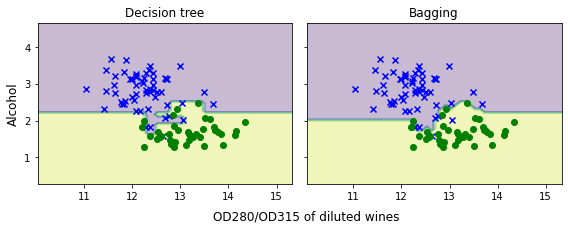

In [15]:
#決定境界をそれぞれ可視化してみる
# baggingのほうが滑らかな決定協会になっていることがわかる
import numpy as np
import matplotlib.pyplot as plt

x_min = X_train.iloc[:, 0].min() - 1
x_max = X_train.iloc[:, 0].max() + 1
y_min = X_train.iloc[:, 1].min() - 1
y_max = X_train.iloc[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, bag],
                        ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0].iloc[:,0],
                       X_train[y_train == 0].iloc[:,1],
                       c='blue', marker='x')

    axarr[idx].scatter(X_train[y_train == 1].iloc[:,0],
                       X_train[y_train == 1].iloc[:,1],
                       c='green', marker='o')

    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='OD280/OD315 of diluted wines',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)

#plt.savefig('images/07_08.png', dpi=300, bbox_inches='tight')
plt.show()

ランダムフォレストなどに代表されるバギングアルゴリズムは、個々の推定機(=決定木など)のバイアスを抑制することはできないが、<br>
複数の推定機を組み合わせることで、バリアンスを抑制することはできる。上の例で剪定していない決定木(高バリアンス低バイアス=過学習)を<br>
つかってバギングを行ったのは、元の決定木が持つ低バイアスという特性を生かしたまま、バリアンスを抑えたかったためである

In [16]:
#ブースティングの仕組みについて
#仕組みとしては、全データポイントに均一な重みをまずは与えて（重み合計が1になるよう）
#弱学習器での正答率を使って、重みの更新係数αjを計算する
#そして、重み更新係数を使い、正答、誤答データポイントそれぞれに重みを更新する
#最終的に全データポイントの重みの合計を1になるよう正規化して、データポイントの新しい重みを得る、これをBoosting回数だけLoopさせる
from sklearn.ensemble import AdaBoostClassifier

#構成要素である弱学習機として、決定株を定義
tree = DecisionTreeClassifier(criterion='entropy',max_depth=1,random_state=1)

#弱学習機の組み合わせでboostingを行うAdaboost
ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500,
                         learning_rate=0.1,
                         random_state=1)

tree.fit(X_train,y_train)
y_tree_train_pred = tree.predict(X_train)
y_tree_test_pred = tree.predict(X_test)

print('tree train prediction accuracy')
print(accuracy_score(y_train,y_tree_train_pred))

print('tree test prediction accuracy')
print(accuracy_score(y_test,y_tree_test_pred))
#決定株では、過学習ではないものの、学習不足になっている傾向がある

tree train prediction accuracy
0.9157894736842105
tree test prediction accuracy
0.875


In [17]:
ada.fit(X_train,y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

print('ada train prediction accuracy')
print(accuracy_score(y_train,y_train_pred))

print('ada test prediction accuracy')
print(accuracy_score(y_test,y_test_pred))
#ADABOOSTでは、訓練データに完全に適合したため、バイアスは減少したかもしれないが
#かえってテストデータへのFitの際の汎化性能が良くない。バリアンスが上がってしまった

ada train prediction accuracy
1.0
ada test prediction accuracy
0.9166666666666666


C:\Users\unlea\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\unlea\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


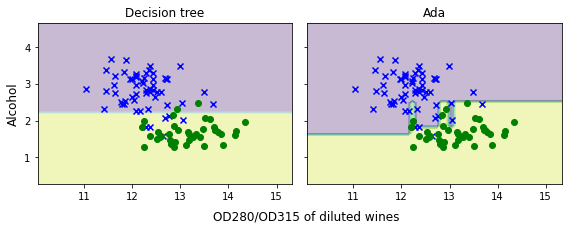

In [18]:
#決定境界をそれぞれ可視化してみる
# Adaboostのほうが滑らかな決定境界になっており、バギングの結果とも近しいことがわかる
import numpy as np
import matplotlib.pyplot as plt

x_min = X_train.iloc[:, 0].min() - 1
x_max = X_train.iloc[:, 0].max() + 1
y_min = X_train.iloc[:, 1].min() - 1
y_max = X_train.iloc[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, ada],
                        ['Decision tree', 'Ada']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0].iloc[:,0],
                       X_train[y_train == 0].iloc[:,1],
                       c='blue', marker='x')

    axarr[idx].scatter(X_train[y_train == 1].iloc[:,0],
                       X_train[y_train == 1].iloc[:,1],
                       c='green', marker='o')

    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='OD280/OD315 of diluted wines',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)

#plt.savefig('images/07_08.png', dpi=300, bbox_inches='tight')
plt.show()